<a href="https://colab.research.google.com/github/z-arabi/SRU-deeplearning-workshop/blob/master/17_Transfer_learning_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

Use Transfer learning as a Feature Extractor



In [1]:
import keras
keras.__version__

'2.13.1'

<div style="direction:rtl;text-align:right;font-family:Tahoma">
The code source is:
</div>

[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff)

<div style="direction:rtl;text-align:right;font-family:Tahoma">
The github source of the code is:
</div>

[François Chollet](http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)


# Using a pre-trained convnet

----

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network
is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original
dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a
generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these
new problems might involve completely different classes from those of the original task. For instance, one might train a network on
ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as
identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning
compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes).
ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat
vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture
for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent
models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing
any new concepts. This may be your first encounter with one of these cutesie model names -- VGG, ResNet, Inception, Inception-ResNet,
Xception... you will get used to them, as they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to leverage a pre-trained network: *feature extraction* and *fine-tuning*. We will cover both of them. Let's start with
feature extraction.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples.
These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution
layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of
convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data
through it, and training a new classifier on top of the output.

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The
reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the
feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer
vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of
classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the
entire picture. Additionally, representations found in densely-connected layers no longer contain any information about _where_ objects are
located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional
feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on
the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual
edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new
dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the
model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the
information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more
general case where the class set of the new problem does not overlap with the class set of the original model.

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from
our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. You can import it from the `keras.applications` module. Here's the list of
image classification models (all pre-trained on the ImageNet dataset) that are available as part of `keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let's instantiate the VGG16 model:

In [2]:
! pip install --quiet kaggle

In [3]:
import os
import getpass

kaggle_username = getpass.getpass('Enter your Kaggle username:')
kaggle_key = getpass.getpass('Enter your Kaggle API key:')

os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

Enter your Kaggle username:··········
Enter your Kaggle API key:··········


In [4]:
! kaggle competitions download -c dogs-vs-cats

 98% 799M/812M [00:05<00:00, 128MB/s]
100% 812M/812M [00:05<00:00, 154MB/s]


In [5]:
! unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
! unzip train.zip
! unzip test1.zip

! mv -f test1 test

In [7]:
import os, shutil

In [8]:
original_dataset_dir = 'train'

base_dir = 'catVsdog'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [9]:
# Copy first 1000 cat images to train_cats_dir
fnames = [f'cat.{i}.jpg' for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = [f'cat.{i}.jpg' for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to test_cats_dir
fnames = [f'cat.{i}.jpg' for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy first 1000 dog images to train_dogs_dir
fnames = [f'dog.{i}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to validation_dogs_dir
fnames = [f'dog.{i}.jpg' for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to test_dogs_dir
fnames = [f'dog.{i}.jpg' for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [10]:
for root, dirs, files in os.walk(base_dir):
  print(root)
  print(len(files))

catVsdog
0
catVsdog/validation
0
catVsdog/validation/cats
500
catVsdog/validation/dogs
500
catVsdog/train
0
catVsdog/train/cats
1000
catVsdog/train/dogs
1000
catVsdog/test
0
catVsdog/test/cats
500
catVsdog/test/dogs
500


In [31]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

# when we change the input shape the output shape will be changed too
'''
input_shape=(224, 224, 3) > block5_pool (MaxPooling2D)  (None, 7, 7, 512)
'''

'\ninput_shape=(224, 224, 3) > block5_pool (MaxPooling2D)  (None, 7, 7, 512)\n'

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected
classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it,
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already
familiar with.

In [32]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed:

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a
standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and
cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the
most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at
all.
* Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This
allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model.
However, for this same reason, this technique is far more expensive than the first one.

We will cover both techniques. Let's walk through the code required to set-up the first one: recording the output of `conv_base` on our
data and using these outputs as inputs to a new model.

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as
their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './catVsdog'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    # for the generator we have to put the images of each class in separate folder
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

# we cache it once

The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must
flatten them to `(samples, 8192)`:

In [14]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and
labels that we just recorded:

In [15]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 3s 9ms/step - loss: 0.7206 - acc: 0.7590 - val_loss: 0.3551 - val_acc: 0.8340
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3395 - acc: 0.8595 - val_loss: 0.2442 - val_acc: 0.8980
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2733 - acc: 0.8900 - val_loss: 0.3141 - val_acc: 0.8740
Epoch 4/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2456 - acc: 0.9010 - val_loss: 0.2390 - val_acc: 0.9020
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2047 - acc: 0.9190 - val_loss: 0.4801 - val_acc: 0.8490
Epoch 6/30
100/100 [==============================] - 1s 7ms/step - loss: 0.1936 - acc: 0.9280 - val_loss: 0.2972 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.1847 - acc: 0.9275 - val_loss: 0.4952 - val_acc: 0.8430
Epoch 8/30
100/100 [==============================] - 1s 8ms/step - loss: 0.

Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

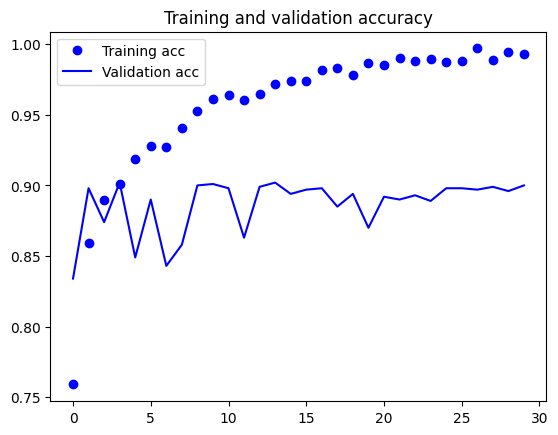

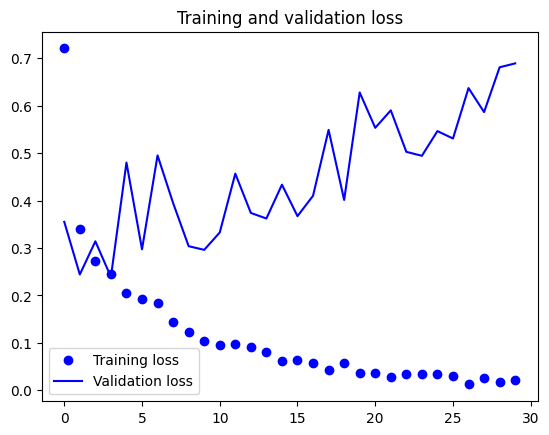

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
'''
We have overfit
We have lots of epochs without training > it goes to memorizing
without training means that the weights are constant
we cach the data
so the operation will be less > speed is too fast
but the model is more in risk of overfitting > why? because we have a constant features >
not learnable > we can't augment the data
'''


We reach a validation accuracy of about 90%, much better than what we could achieve in the previous section with our small model trained from
scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate.
This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.

Now, let's review the second technique we mentioned for doing feature extraction, which is much slower and more expensive, but which allows
us to leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs. Note that this
technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you
cannot run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can add a model (like our `conv_base`) to a `Sequential` model just like you would add a layer.
So you can do the following:

In [33]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [34]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2
million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of
layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized,
very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [35]:
'''
If we want to train the network without freezing:
1. the to FC layers' weights are initialied randomly
2. that' why they give high errors > so the error back propagate in the network
3. ruin the weights of VGG layers
'''

"\nIf we want to train the network without freezing:\n1. the to FC layers' weights are initialied randomly\n2. that' why they give high errors > so the error back propagate in the network\n3. ruin the weights of VGG layers\n"

In [37]:
'''
VGG16 > 13 conv +  2 FC  + softmax
with top=false > 13 conv
trainable weights > for each layer we have one matrix Wi and one vector bias
'''
print(len(conv_base.trainable_weights))

print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

26
This is the number of trainable weights before freezing the conv base: 30


In [38]:
conv_base.trainable = False

In [39]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [ ]:
model.summary()

With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per
layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model.
If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [40]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Epoch 1/30


<ipython-input-40-0909a1dd9664>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 - 23s - loss: 0.7602 - acc: 0.7030 - val_loss: 0.5701 - val_acc: 0.7290 - 23s/epoch - 234ms/step
Epoch 2/30
100/100 - 19s - loss: 0.4742 - acc: 0.7750 - val_loss: 0.3747 - val_acc: 0.8190 - 19s/epoch - 186ms/step
Epoch 3/30
100/100 - 20s - loss: 0.4159 - acc: 0.8095 - val_loss: 0.2528 - val_acc: 0.8950 - 20s/epoch - 197ms/step
Epoch 4/30
100/100 - 21s - loss: 0.3720 - acc: 0.8250 - val_loss: 0.2891 - val_acc: 0.8680 - 21s/epoch - 213ms/step
Epoch 5/30
100/100 - 22s - loss: 0.3651 - acc: 0.8320 - val_loss: 0.2663 - val_acc: 0.8910 - 22s/epoch - 217ms/step
Epoch 6/30
100/100 - 19s - loss: 0.3526 - acc: 0.8420 - val_loss: 0.2639 - val_acc: 0.8880 - 19s/epoch - 194ms/step
Epoch 7/30
100/100 - 20s - loss: 0.3534 - acc: 0.8380 - val_loss: 0.3168 - val_acc: 0.8470 - 20s/epoch - 202ms/step
Epoch 8/30
100/100 - 19s - loss: 0.3600 - acc: 0.8430 - val_loss: 0.2576 - val_acc: 0.8920 - 19s/epoch - 187ms/step
Epoch 9/30
100/100 - 19s - loss: 0.3321 - acc: 0.8470 - val_loss: 0.2537 - val_acc:

In [41]:
model.save('cats_and_dogs_small_3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Let's plot our results again:

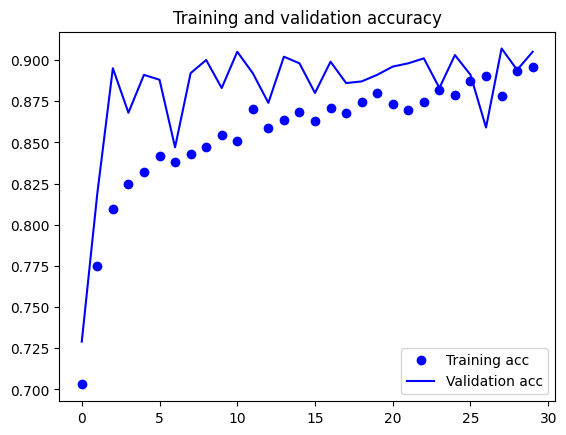

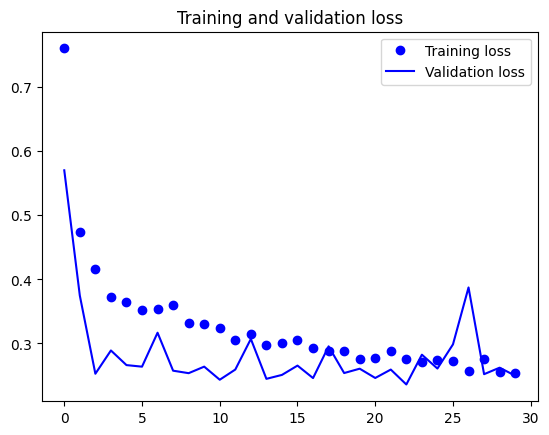

In [42]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.